In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# svg, png. no inline pdf.

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns

In [4]:
import numpy as np
import scipy
import scipy.stats
import pandas

In [5]:
import sklearn
import sklearn.decomposition
import sklearn.feature_extraction
import sklearn.feature_extraction.text

In [6]:
import collections
from pprint import pprint
import cPickle as pickle
import unicodecsv as csv
import json
import re

In [7]:
import analysis_tools

In [8]:
np.seterr(divide='raise', over='raise', under='raise', invalid='raise');

# Data preparation

Let's load the cities. We'll filter out any groups that weren't 'active' during the period of study (2012-2014, inclusive). Active groups are those that have had an event with at least two attendees.

In [52]:
all_city2groups = analysis_tools.get_city2groups('GB')

db_all_groups = sum(all_city2groups.itervalues(), [])
    # all groups loaded from DB, including those not assigned to cities

In [10]:
print "number of groups without city", len(all_city2groups.get('<unknown>', []))
if '<unknown>' in all_city2groups:
    del all_city2groups['<unknown>']

num_grps_before_filter = sum(len(groups) for groups in all_city2groups.itervalues())
print "number of groups before filtering:", num_grps_before_filter

number of groups without city 47
number of groups before filtering: 1541


In [11]:
def is_active(grp):
    for event in grp['events_in_window']:
        if len(event['attendee_ids']) >= 2:
            return True
    return False
        
for city_ident in all_city2groups.iterkeys():
    all_city2groups[city_ident] = filter(is_active, all_city2groups[city_ident])
    
num_grps_after_filter = sum(len(groups) for groups in all_city2groups.itervalues())
print "number of groups after filtering:", num_grps_after_filter

number of groups after filtering: 932


How many usable groups do we have per city?

In [12]:
group_counts = collections.Counter({city: len(groups) for city, groups in all_city2groups.iteritems()})

for indx, (k, v) in enumerate(group_counts.most_common(25)):
    print "%-10s%-10s%-30s(pop %d)" % (indx+1, v, k, k.pop)
print "..."

1         588       UK::London                    (pop 12972492)
2         44        UK::Bristol metropolitan area (pop 1059746)
3         39        UK::Manchester metropolitan area(pop 2460991)
4         34        UK::Cambridge                 (pop 361461)
5         28        UK::Birmingham metropolitan area(pop 3621263)
6         26        UK::Edinburgh                 (pop 214846)
7         20        UK::Brighton/Worthing/Littlehampton(pop 566617)
8         16        UK::Oxford                    (pop 311481)
9         15        UK::Leeds - Bradford metropolitan area(pop 2210426)
10        11        UK::Liverpool/Birkenhead metropolitan area(pop 2060653)
11        10        UK::Cardiff and South Wales valleys metropolitan area(pop 1142941)
12        9         UK::Leicester                 (pop 747425)
13        8         UK::Norwich                   (pop 428646)
14        7         UK::Belfast                   (pop 857106)
15        7         UK::Tyneside metropolitan area(pop 139

In [13]:
min_num_groups = 5
keep_cities = [city for city, count in group_counts.iteritems() if count >= min_num_groups]

print "%d cities with at least %s Tech groups:" % (len(keep_cities), min_num_groups)
print ', '.join(map(str, keep_cities))

city2groups = {city: all_city2groups[city] for city in keep_cities}  # all cities for study

18 cities with at least 5 Tech groups:
UK::Norwich, UK::Glasgow, UK::Birmingham metropolitan area, UK::Belfast, UK::Liverpool/Birkenhead metropolitan area, UK::Cardiff and South Wales valleys metropolitan area, UK::Leicester, UK::Oxford, UK::Edinburgh, UK::Tyneside metropolitan area, UK::London, UK::Manchester metropolitan area, UK::Cambridge, UK::Brighton/Worthing/Littlehampton, UK::Bristol metropolitan area, UK::Nottingham-Derby metropolitan area, UK::Leeds - Bradford metropolitan area, UK::Sheffield metropolitan area


In [14]:
num_study_grps = sum(len(groups) for groups in city2groups.itervalues())
print "groups crawled (before filtering)                  ", num_grps_before_filter
print "active groups (after filtering)                    ", num_grps_after_filter
print "active groups in active cities (focus on analysis) ", num_study_grps

groups crawled (before filtering)                   1541
active groups (after filtering)                     932
active groups in active cities (focus on analysis)  880


### Build dataframe with descriptors of each city

In [15]:
# city name; longitude; latitude;
# population (geodemographic); num users subscribed (unique); num users attended event (unique)
# num events; num meetup groups

def extract_active_users(groups):
    # active = attended at least one event
    uniqs = set()
    for group in groups:
        for event in group['events_in_window']:
            uniqs.update(event['attendee_ids'])
    return tuple(uniqs)
def count_active_users(groups):
    return len(extract_active_users(groups))

def extract_subscribed_users(groups):
    # subscribed = subscribed to at least one group
    uniqs = set()
    for group in groups:
        uniqs.update(group['member_ids'])
    return tuple(uniqs)
def count_subscribed_users(groups):
    return len(extract_subscribed_users(groups))

rows = []
for city, groups in city2groups.iteritems():
    row = collections.OrderedDict()
    pop = float(city.pop)
    row['name'] = str(city)
    row['lon'] = city.lon
    row['lat'] = city.lat
    row['pop'] = pop
    row['groups'] = float(len(groups))
        # by way of previous filtering, these are 'active' gruops -- at least one event
        # with two attendees
    row['users_members'] = float(count_subscribed_users(groups))
    row['users_attendees'] = float(count_active_users(groups))
    # population-normed measures:
    row['groups_per_100k'] = row['groups'] / (pop/10**5)
    row['users_members_per_100k'] = row['users_members'] / (pop/10**5)
    row['users_attendees_per_100k'] = row['users_attendees'] / (pop/10**5)
    rows.append(row)

df_cities = pandas.DataFrame(rows, columns=rows[0].keys())
print df_cities

                                                 name       lon        lat  \
0                                          UK::London -0.163732  51.445057   
1                 UK::Brighton/Worthing/Littlehampton -0.165454  50.858044   
2                       UK::Bristol metropolitan area -2.547128  51.445594   
3                                       UK::Edinburgh -3.128971  55.873162   
4              UK::Leeds - Bradford metropolitan area -1.625681  53.845583   
5          UK::Liverpool/Birkenhead metropolitan area -2.833608  53.366300   
6                                          UK::Oxford -1.291842  51.783367   
7                                       UK::Leicester -1.098805  52.642711   
8                                         UK::Norwich  1.286582  52.658770   
9                    UK::Manchester metropolitan area -2.207738  53.454272   
10                                        UK::Glasgow -4.340771  55.870583   
11                                      UK::Cambridge  0.196639 

### Other data for future reference

In [16]:
# canonical ordering of cities:
all_cities = tuple(sorted(city2groups.iterkeys()))

# Geography of meetups and activity

In [17]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt

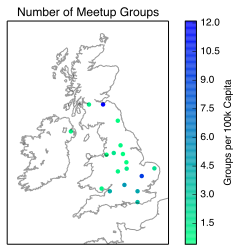

In [18]:
fig, ax = plt.subplots(1, 1)

# use mercator
basem = Basemap(llcrnrlon=-11.372070, llcrnrlat=48.507377, urcrnrlon=2.5, urcrnrlat=59.7,
            rsphere=(6378137.00, 6356752.3142),
            resolution='i', projection='merc',
            lat_0=40., lon_0=-20., lat_ts=20.)

# background and ornaments
basem.drawcoastlines(color=[0, 0, 0, 0.4])
#basem.fillcontinents()

# meridians
#basem.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

ax.set_title('Number of Meetup Groups');

#
# add points

x, y = basem(df_cities['lon'].values, df_cities['lat'].values)
mags = df_cities['groups_per_100k'].values
sc = basem.scatter(x, y, s=20, marker='o', linewidths=0, c=mags, cmap='winter_r')  # 'RdYlBu' 'winter'

cbar = plt.colorbar(sc)
cbar.set_label('Groups per 100k Capita')

In [ ]:
# Where do events happen? 
# Include all groups in the DB (inc. not assigned to city).
# Ignore events w/o venues

seq_lon = []
seq_lat = []
for group in db_all_groups:
    for event in group['events_in_window']:
        if 'venue' not in event:
            continue
        venue = event['venue']
        seq_lon.append(venue['lon'])
        seq_lat.append(venue['lat'])

In [92]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset 

#
# Basemap
fig = plt.figure(figsize=[9, 6])
gs = mpl.gridspec.GridSpec(2, 3, wspace=0.02, hspace=0.01)
ax1 = plt.subplot(gs[:,:-1])
ax2 = plt.subplot(gs[0,-1])
ax3 = plt.subplot(gs[1,-1])

viewports = [
    {'llcrnrlon': -11.372070, 'llcrnrlat': 48.507377, 'urcrnrlon': 2.5, 'urcrnrlat': 59.7},  # UK
    {'llcrnrlon': -5.972070, 'llcrnrlat': 49.807377, 'urcrnrlon': 2.0, 'urcrnrlat': 54.7},  # eng&wal
    {'llcrnrlon': -0.406744, 'llcrnrlat': 51.407223, 'urcrnrlon': 0.151312, 'urcrnrlat': 51.651046},  # London
    ]

for ax, view in zip([ax1, ax2, ax3], viewports):
    basem = Basemap(rsphere=(6378137.00, 6356752.3142),
                    resolution='i', projection='merc',
                    lat_0=40., lon_0=-20., lat_ts=20., ax=ax,
                    **view)
    basem.drawcoastlines(color=[0, 0, 0, 0.4])

    x, y = basem(seq_lon, seq_lat)
    
    basem.scatter(x, y, s=1.5, marker='o', linewidths=0, c='b', alpha=0.2)

ax1.set_title('UK')
ax2.set_title('England & Wales')
ax3.set_title('London')


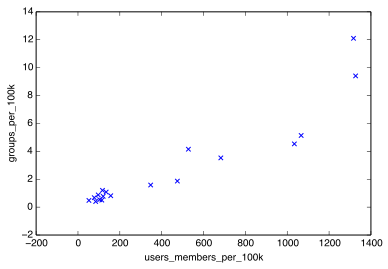

In [20]:
# population, number of groups, number of (unique) active usres (by event attendance)

df_cities.plot(kind='scatter', x='users_members_per_100k', y='groups_per_100k', marker='x')
#, s=df_cities['users_attendees']

# Co-visiting

In [21]:
print "DELETE THIS"

# unique users who've attended an event in city A
# unique users who've attended an event in both city A and city B
# why does this happen? another place has more expertise?
# your own city is missing a meetup on a particular topic?
# we'll restrict ourselves to users who've *attended* events in
# both cities
# other factors: geographic distance, transport
# other caveats: triangle effect (lives in London, visits Oxf and Camb)

N = len(all_cities)
matrix_covisitors = np.zeros([N, N], np.float64)

covis_counts = collections.Counter()  # citya, cityb -> num co-visitors
vis_counts = {}  # city -> num co-visitors

for indx_i, city_i in enumerate(all_cities):
    users_i = frozenset(extract_active_users(city2groups[city_i]))
    vis_counts[city_i] = float(len(users_i))
    
    for indx_j, city_j in enumerate(all_cities):
        if indx_i == indx_j:
            continue
        users_j = frozenset(extract_active_users(city2groups[city_j]))
        num_covisitors = float(len(users_i & users_j))
        
        matrix_covisitors[indx_i,indx_j] = num_covisitors
        if indx_i < indx_j:
            covis_counts[(city_i,city_j)] = num_covisitors

assert np.all(matrix_covisitors == matrix_covisitors.T)

DELETE THIS


In [22]:
for (city_i, city_j), c in covis_counts.most_common(8):
    print c, city_i, " /// ", city_j

400.0 UK::London  ///  UK::Brighton/Worthing/Littlehampton
398.0 UK::London  ///  UK::Cambridge
331.0 UK::London  ///  UK::Bristol metropolitan area
225.0 UK::London  ///  UK::Oxford
201.0 UK::London  ///  UK::Birmingham metropolitan area
194.0 UK::London  ///  UK::Manchester metropolitan area
169.0 UK::London  ///  UK::Tyneside metropolitan area
103.0 UK::Manchester metropolitan area  ///  UK::Liverpool/Birkenhead metropolitan area


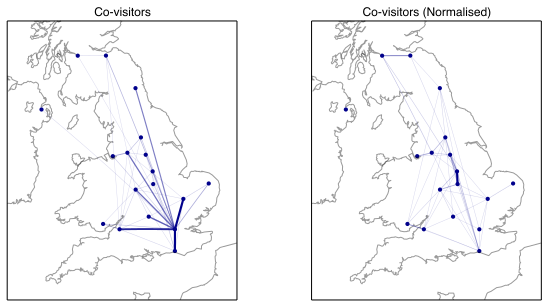

In [107]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

#
# Compute city-to-city magnitudes
pairs = []
mags_covisitors = np.zeros([len(covis_counts)], np.float64)  # abs num co-visitors
mags_ratios = np.zeros([len(covis_counts)], np.float64)      # ratio s_ij / m_i * m_j
for indx, (pair, num_covisits) in enumerate(covis_counts.iteritems()):
    cA, cB = pair
    pairs.append(pair)
    mags_covisitors[indx] = num_covisits
    mags_ratios[indx] = num_covisits / (vis_counts[cA] * vis_counts[cB])

#
# Gen params
color = 'darkblue'
percentile = 70
    
#
# General basemap params
params = {'llcrnrlon': -7.372070, 'llcrnrlat': 49.507377, 'urcrnrlon': 2.5, 'urcrnrlat': 56.7}  # all UK
#params = {'llcrnrlon': -5.972070, 'llcrnrlat': 49.807377, 'urcrnrlon': 2.0, 'urcrnrlat': 54.7}  # eng&wal


#
#
# Draw maps
#
for ax, mags in zip([ax1, ax2], [mags_covisitors, mags_ratios]):

    # boilerplate...
    basem = Basemap(rsphere=(6378137.00, 6356752.3142), resolution='i',  # c l h f
                projection='merc', lat_0=40., lon_0=-20., lat_ts=20.,
                ax=ax, **params)
    basem.drawcoastlines(color=[0, 0, 0, 0.4])
    
    # viz
    mag_viz_min = np.percentile(mags, percentile)
    
    max_lw = 2.5
    norm_lw = mpl.colors.Normalize(-max(mags)/4, max(mags)*1.2)

    norm_color = mpl.colors.Normalize(-max(mags)/6, max(mags))
    for (cA, cB), mag in zip(pairs, mags.flat):
        if mag <= mag_viz_min:
            continue
        basem.drawgreatcircle(cA.lon, cA.lat, cB.lon, cB.lat, c=color,
                              alpha=norm_color(mag),  #alpha=0.6, 
                              lw=norm_lw(mag)*max_lw)
    
    x, y = basem(df_cities['lon'].values, df_cities['lat'].values)
    sc = basem.scatter(x, y, s=18, marker='o', linewidths=0, c=color)  # 'RdYlBu' 'winter'

ax1.set_title('Co-visitors')
ax2.set_title('Co-visitors (Normalised)')

In [ ]:
#community detec? color nodes according to community detec?
#centrality?

In [120]:
import networkx as nx

g = nx.Graph()
for (cA, cB), mag in zip(pairs, np.array(mags_ratios)):
    g.add_edge(cA, cB, weight=mag)
    
node2cent = nx.katz_centrality(g)
for node, cent in sorted(node2cent.items(), key=lambda item: item[1], reverse=True):
    print cent, node

0.235708921502 UK::Nottingham-Derby metropolitan area
0.235706814653 UK::Leicester
0.235704025504 UK::Sheffield metropolitan area
0.235702634735 UK::Leeds - Bradford metropolitan area
0.235702506699 UK::Manchester metropolitan area
0.235702392984 UK::Birmingham metropolitan area
0.235702091213 UK::Glasgow
0.235702017492 UK::Edinburgh
0.235701964785 UK::Bristol metropolitan area
0.235701855889 UK::Brighton/Worthing/Littlehampton
0.235701641465 UK::Cardiff and South Wales valleys metropolitan area
0.235701106483 UK::Liverpool/Birkenhead metropolitan area
0.235701020259 UK::Cambridge
0.235700603379 UK::Tyneside metropolitan area
0.235700597151 UK::Oxford
0.235700459712 UK::London
0.235700348384 UK::Norwich
0.23569968464 UK::Belfast


# Topic modelling

### Build clustering of related groups via an LSA (hidden) topic model trained on keywords

The topic model will be trained on all 'active' groups.

In [166]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

In [167]:
# recall all_city2groups from earlier. this gives us the active groups in the
# UK, including those will filtered out.

groupname2doc = {}
seq_groups = sum(all_city2groups.values(), [])
corpus = []
for group in seq_groups:
    doc = []
    for topic in group['topics']:
        txt = topic['urlkey']
        assert ' ' not in txt
        doc.append(txt)
    corpus.append(doc)
    groupname2doc[group['name']] = doc
assert len(seq_groups) == len(corpus)

print "num groups", len(seq_groups)
print "num unique topics", len(frozenset(sum(corpus, [])))
corpus = [','.join(doc) for doc in corpus]

num groups 1588
num unique topics 2743


In [168]:
def tokenizer(s):
    return s.split(',')

vectorizer = TfidfVectorizer(tokenizer=tokenizer)  #max_df=0.5,stop_words='english'#~
#vectorizer = CountVectorizer(tokenizer=tokenizer)  #max_df=0.5,stop_words='english'#~
X_tfidf = vectorizer.fit_transform(corpus)

X_tfidf.shape

feature_names = vectorizer.get_feature_names()

print X_tfidf.shape
print "num features ", len(feature_names)
print "num groups   ", len(seq_groups)

(1588, 2743)
num features  2743
num groups    1588


In [169]:
lsa = TruncatedSVD(n_components=220)  # default=2
lsa = lsa.fit(X_tfidf)

print sum(lsa.explained_variance_ratio_ )
print lsa.explained_variance_ratio_[:10], '...?'

X_lsa = lsa.transform(X_tfidf)
X_lsa = Normalizer(copy=False).fit_transform(X_lsa)

print X_lsa.shape

0.619861468484
[ 0.01713606  0.02541703  0.01828717  0.01645949  0.01358159  0.01257541
  0.01098037  0.01070957  0.00987151  0.00976447] ...?
(1588, 220)


In [181]:
km = KMeans(n_clusters=10)

labels = km.fit_predict(X_lsa)
    #~ not cosine!

print labels.shape
print labels.min(), labels.max()

(1588,)
0 9


In [182]:
cluster2names = collections.defaultdict(lambda: [])
    # map cluster ID to list of group names belonging to cluster
    
cluster2rowindexes = collections.defaultdict(lambda: [])
    # map cluster ID to list of row indexes in the X_* matrices

for row_indx, (cluster_id, group) in enumerate(zip(labels, seq_groups)):
    cluster2rowindexes[cluster_id].append(row_indx)
    cluster2names[cluster_id].append(group['name'])

#
# finally, build assignment of groupid to clusterid
groupid2clusterid = dict(zip([group['id'] for group in seq_groups], labels))

In [183]:
def top_terms(row_indx, k=3):
    # return the top k terms and their weights
    vec = X_tfidf[row_indx,:]
    items = zip(feature_names, vec.toarray().flat)
    items.sort(key=lambda item: item[1], reverse=True)
    return items[:k]

for clust_id, grp_names in cluster2names.iteritems():
    row_indexes = cluster2rowindexes[clust_id]
    
    print '\n\nCLUSTER %s    (%s groups)' % (clust_id, len(grp_names))
    print
    
    for name, row_indx in zip(grp_names, row_indexes):
        assert name == seq_groups[row_indx]['name']
        print name.upper(), "     [%d]" % groupid2clusterid[seq_groups[row_indx]['id']]
        print "   " + ', '.join("%s (%.2f)" % (term, tfidf) for term, tfidf in top_terms(row_indx, k=2))



CLUSTER 0    (100 groups)

GLASGOW MOBILE DEVELOPERS GROUP      [0]
   xamarin (0.39), net-developers (0.37)
HACKERNEST GLASGOW TECH SOCIALS      [0]
   green-technology (0.46), information-technology-in-business (0.38)
BATH & FROME WWDC KEYNOTE      [0]
   mac (0.43), apple (0.42)
SUSSEX ANDROID      [0]
   android-development-training (0.42), android-sdk (0.42)
DIGITAL HENLEY      [0]
   iphone-ipad-ios-developers (0.46), ios (0.36)
WEST MIDLANDS IOS AND ANDROID APP DEVELOPMENT MEETUP      [0]
   ios-and-android-application-development (0.38), android-app-design (0.36)
HYDRAHACK - WEB / DEVELOPER MEETUP      [0]
   ruby-on-rails (0.37), ruby (0.36)
BIRMINGHAM XAMARIN MOBILE CROSS PLATFORM USER GROUP      [0]
   windows-8-development (0.46), xamarin (0.44)
GOOGLE DEVELOPER GROUP (GDG) BIRMINGHAM      [0]
   gtug (0.36), google-maps (0.34)
CORONA SDK - BIRMINGHAM UK MEETUP      [0]
   lua-programming (0.61), corona-sdk (0.59)
BASH!      [0]
   software-engineering (0.39), functional-

### Build profile of each city according to group type

In [184]:
seq_cities = city2groups.keys()

corpus = []
    # each doc is a city

for city, groups in city2groups.iteritems():
    clust_ids = [groupid2clusterid[group['id']] for group in groups]
    doc = ','.join(map(str, clust_ids))
    corpus.append(doc)

In [206]:
def tokenizer(s):
    return s.split(',')

#vectorizer = TfidfVectorizer(tokenizer=tokenizer)  #max_df=0.5,stop_words='english'#~
vectorizer = CountVectorizer(tokenizer=tokenizer)  #max_df=0.5,stop_words='english'#~

X_count = vectorizer.fit_transform(corpus).astype(np.float64)
X_freq = X_count.copy()

for row in xrange(X_freq.shape[0]):
    X_freq[row,:] = X_freq[row,:] / X_freq[row,:].sum()

print X_freq.shape
for indx in range(len(seq_cities))[:3]:
    print seq_cities[indx]
    print X_freq.toarray()[indx,:]
print "..."

(18, 10)
UK::London
[ 0.07653061  0.09013605  0.05272109  0.04081633  0.08163265  0.09863946
  0.07142857  0.30612245  0.14455782  0.03741497]
UK::Brighton/Worthing/Littlehampton
[ 0.    0.15  0.    0.05  0.15  0.15  0.05  0.3   0.15  0.  ]
UK::Bristol metropolitan area
[ 0.06818182  0.06818182  0.04545455  0.          0.13636364  0.06818182
  0.04545455  0.25        0.27272727  0.04545455]
...


[ 0.29810341  0.22135774]


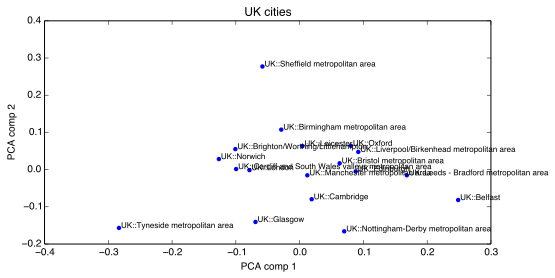

In [207]:
pca = sklearn.decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(X_freq.toarray())
print pca.explained_variance_ratio_
comp1 = X_pca[:,0]
comp2 =  X_pca[:,1]

fig, ax = plt.subplots(1, 1, figsize=[8,4])
sc = plt.scatter(comp1, comp2, linewidths=0)

plt.xlabel('PCA comp 1')
plt.ylabel('PCA comp 2')
plt.title('UK cities')

for x, y, name in zip(comp1, comp2, seq_cities):
    plt.annotate(name, xy=[x, y], fontsize=8, textcoords='offset points', xytext=[2, 0])

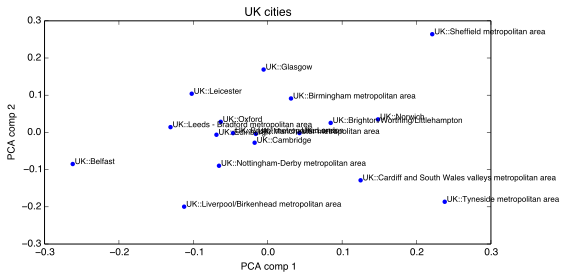

In [210]:
from sklearn.manifold import MDS
dist = sklearn.metrics.pairwise.cosine_distances(X_count)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
X_r = mds.fit_transform(dist)  # shape (n_components, n_samples)
comp1 = X_r[:,0]
comp2 =  X_r[:,1]

fig, ax = plt.subplots(1, 1, figsize=[8,4])
sc = plt.scatter(comp1, comp2, linewidths=0)

plt.xlabel('PCA comp 1')
plt.ylabel('PCA comp 2')
plt.title('UK cities')

for x, y, name in zip(comp1, comp2, seq_cities):
    plt.annotate(name, xy=[x, y], fontsize=8, textcoords='offset points', xytext=[2, 0])

# Comparison with naive approach: PCA on city tag counts

In [31]:
topic_counts = collections.Counter()

for city, groups in city2groups.iteritems():
    for group in groups:
        num_members = len(group['member_ids'])
        for topic_dict in group['topics']:
            topic_name = topic_dict['name']
            topic_counts[topic_name] += 1    #num_members. not ideal. geodemographic issues. #~

In [32]:
print "There are %s topics\n" % (len(topic_counts))
for indx, (k, v) in enumerate(topic_counts.most_common(10)):
    print "%-10s%-10s%s" % (indx+1, v, k)
print "..."

There are 2036 topics

1         251       Software Development
2         236       Computer programming
3         228       Web Development
4         202       Open Source
5         201       New Technology
6         188       Web Technology
7         118       Web Design
8         117       Entrepreneurship
9         117       Technology
10        115       Mobile Development
...


Obtain topic count for each city.

In [33]:
# extract canonical list of topics
topics = tuple(sorted(topic_counts.iterkeys()))

In [34]:
# build histogram of topics in each city
city2topics = {city: collections.Counter() for city in all_cities}

for city, groups in city2groups.iteritems():
    for group in groups:
        for topic_dict in group['topics']:
            topic_name = topic_dict['name']
            city2topics[city][topic_name] += 1

In [35]:
# obtain counts
# sigs[row,col] gives the count of occurrences of topic `col` in city `row`
sigs = np.zeros([len(all_cities), len(topics)], dtype=np.float64)
for row, city in enumerate(all_cities):
    for col, topic in enumerate(topics):
        sigs[row,col] = city2topics[city][topic]
print sigs.shape

(18, 2036)


In [36]:
# transformations...

# normalise counts (sigs is now normed histogram)
#for row, city in enumerate(all_cities):
#    sigs[row,:] = sigs[row,:] / sigs[row,:].sum()

# or use TFIDF
TFIDF = sklearn.feature_extraction.text.TfidfTransformer()
sigs = TFIDF.fit_transform(sigs).toarray()
print sigs.shape

(18, 2036)


Let's check some particular examples...

In [37]:
examples = ['Cardiff', 'Brighton', 'Birmingham']
for part in examples:
    indx_city = None
    for indx, city in enumerate(all_cities):
        if part in unicode(city):
            indx_city = indx
            break
    assert indx_city is not None
    
    pairs = zip(sigs[indx_city,:], topics)
    pairs.sort(reverse=True)
    print city
    print "\t", pairs[:2]
    print "\t", city2topics[city].most_common(2)

UK::Cardiff and South Wales valleys metropolitan area
	[(0.31099990478259831, u'Tech Talks'), (0.16197736215670772, u'Web Standards')]
	[(u'Tech Talks', 3), (u'Software Development', 3)]
UK::Brighton/Worthing/Littlehampton
	[(0.1444377335157116, u'Open Source'), (0.14021595707749154, u'JVM Languages')]
	[(u'Web Development', 5), (u'Open Source', 5)]
UK::Birmingham metropolitan area
	[(0.27795607662673072, u'Computer programming'), (0.2139336700244158, u'Software Development')]
	[(u'Computer programming', 13), (u'Web Development', 10)]


### Clustering

In [38]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram

In [39]:
sim = cosine_similarity(sigs)
dist = 1 - sim

In [40]:
def top_topics(city_indx, k=3):
    # return the top `k` topics for city all_cities[city_indx]
    pairs = zip(sigs[city_indx,:], topics)
    pairs.sort(reverse=True)
    return [pair[1] for pair in pairs[:k]]

for indx, city in enumerate(all_cities):
    print city, top_topics(indx, k=3)

UK::Glasgow [u'C#', u'.NET', u'Lean Six Sigma']
UK::London [u'Software Development', u'New Technology', u'Open Source']
UK::Manchester metropolitan area [u'Software Development', u'Web Development', u'Web Design']
UK::Liverpool/Birkenhead metropolitan area [u'Web Design', u'User Experience', u'CSS']
UK::Birmingham metropolitan area [u'Computer programming', u'Software Development', u'Web Development']
UK::Leicester [u'Computer programming', u'Mobile Technology', u'Entrepreneurship']
UK::Cambridge [u'Software Development', u'Web Development', u'Computer programming']
UK::Bristol metropolitan area [u'Software Development', u'Computer programming', u'Bristol']
UK::Nottingham-Derby metropolitan area [u'Computer programming', u'Software Development', u'C#']
UK::Oxford [u'New Technology', u'Machine Learning', u'Computer programming']
UK::Cardiff and South Wales valleys metropolitan area [u'Tech Talks', u'Web Standards', u'Cloud Computing']
UK::Norwich [u'Computer programming', u'Internet Pro

In [41]:
#which two cities the most similar according to tf-idf and cosine-similarity?

pair = (np.tril(sim, -1) == np.tril(sim, -1).max()).nonzero()
print "most similar cities:"
print map(str, [all_cities[indx] for indx in pair])

pair = (np.tril(dist, -1) == np.tril(dist, -1).max()).nonzero()
print "least similar cities"
print map(str, [all_cities[indx] for indx in pair])

most similar cities:
['UK::Bristol metropolitan area', 'UK::London']
least similar cities
['UK::Sheffield metropolitan area', 'UK::Nottingham-Derby metropolitan area']


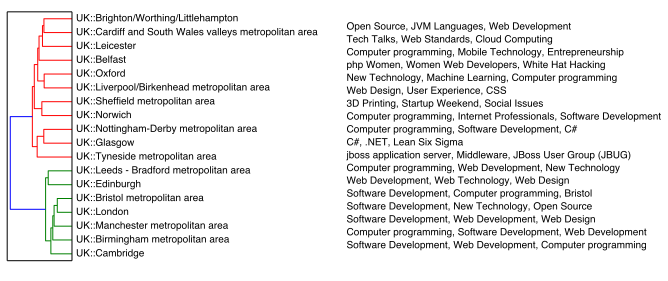

In [42]:
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4)) # set size
dct = dendrogram(linkage_matrix, orientation="right", labels=all_cities, ax=ax1)

ax1.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
#plt.savefig('topics_tfidf_cosine_dendogram.png', dpi=200)

# list top three topics alongside
#topdown_cities = reversed([all_cities[i] for i in dct['leaves']])
annotations = []
for city_indx in reversed(dct['leaves']):
    city = all_cities[city_indx]
    topics_str = ', '.join(top_topics(city_indx))
    annotations.append(topics_str)
ax2.text(0, 0.5, '\n'.join(annotations), linespacing=1.45, va='center')
ax2.axis('off');

### Similarity visualisation via multi-dimensional scaling

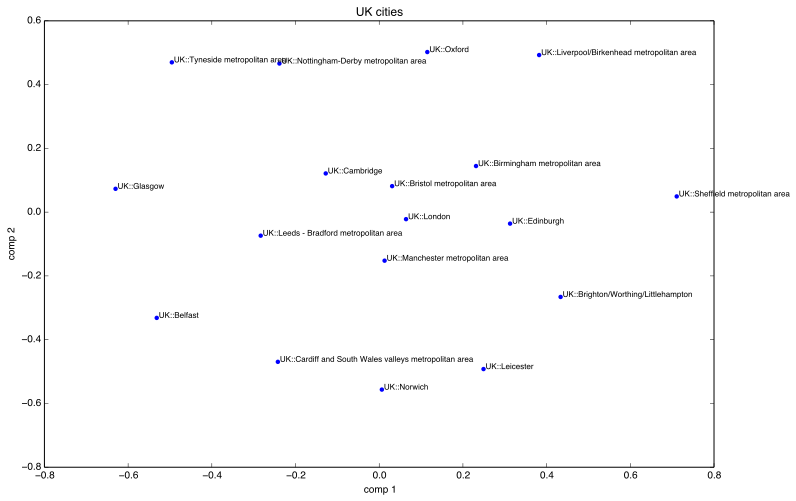

In [43]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

X_r = mds.fit_transform(dist)  # shape (n_components, n_samples)

comp1 = X_r[:,0]
comp2 =  X_r[:,1]

fig, ax = plt.subplots(1, 1, figsize=[12,8])
sc = plt.scatter(comp1, comp2, linewidths=0,
                 #cmap='RdYlBu', c=list(lons.flat)
                )  # 'RdYlBu' 'winter'

plt.xlabel('comp 1')
plt.ylabel('comp 2')
plt.title('UK cities')
#cbar = plt.colorbar(sc)
#cbar.set_label('longitude')

for x, y, name in zip(comp1, comp2, all_cities):
    plt.annotate(name, xy=[x, y], fontsize=8, textcoords='offset points', xytext=[2, 0])

### Apply PCA

In [44]:
pca = sklearn.decomposition.PCA(n_components=2)
X_r = pca.fit(sigs).transform(sigs)

print pca.explained_variance_ratio_

[ 0.0998731  0.089888 ]


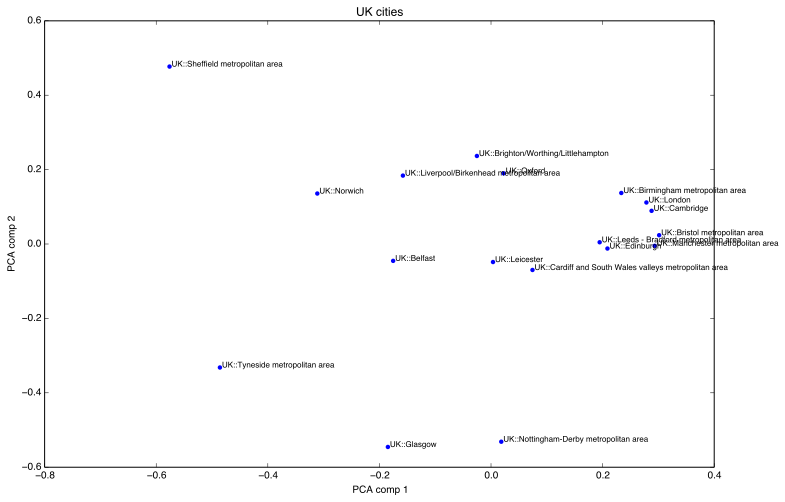

In [45]:
comp1 = X_r[:,0]
comp2 =  X_r[:,1]

fig, ax = plt.subplots(1, 1, figsize=[12,8])
sc = plt.scatter(comp1, comp2, linewidths=0,
                 #cmap='RdYlBu', c=list(lons.flat)
                )  # 'RdYlBu' 'winter'

plt.xlabel('PCA comp 1')
plt.ylabel('PCA comp 2')
plt.title('UK cities')
#cbar = plt.colorbar(sc)
#cbar.set_label('longitude')

for x, y, name in zip(comp1, comp2, all_cities):
    plt.annotate(name, xy=[x, y], fontsize=8, textcoords='offset points', xytext=[2, 0])